<a href="https://colab.research.google.com/github/ValentinoMalakianno/Pembelajaran_Mesin2023/blob/main/Jobsheet10_MachineLearning_ValentinoMalakianno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Valentino Malakianno Putra Nasima**
###3**G**
###**2141720099**
###**Link Github :**
https://github.com/ValentinoMalakianno/Pembelajaran_Mesin2023/blob/main/Jobsheet10_MachineLearning_ValentinoMalakianno.ipynb

**Job Sheet 10 : Recurrent Neural Network (RNN)**

RNN untuk Analisis Sentimen

Setup

Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Setup input pipeline

Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'dear god where do i begin. this is bar none the best movie i\'ve ever seen. the camera angles are great but in my opinion the acting was the best. why the script writers for this movie aren\'t writing big budget films i will never understand. another is the cast. it is great. this is the best ted raimi film out there for sure. i know some of you out there are probably thinking "no way he has plenty better" but no your wrong. raptor island is a work of art. i hope it should have goten best movie of the year instead of that crappy movie Crash with a bunch of no names AND no raptors. i believe this movie is truly the most wonderful thing EVER.'
 b"Cute and playful, but lame and cheap. 'Munchies' is another Gremlins clone to come out from the 80s. I'm not much of a fan of the imitations.<br /><br />First it was the excellent 'Gremlins'.<br /><br />Then came the very average 'Critters'.<br /><br />Lets not forget the lousy 'Ghoulies'.<br /><br />But the complete pits would have t

**Buat Teks Encoder**

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi:

In [7]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):

In [8]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  1, 590, 113, ...,   0,   0,   0],
       [  1,   3,   1, ...,   0,   0,   0],
       [835,   1,   5, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu: -Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation". -Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'dear god where do i begin. this is bar none the best movie i\'ve ever seen. the camera angles are great but in my opinion the acting was the best. why the script writers for this movie aren\'t writing big budget films i will never understand. another is the cast. it is great. this is the best ted raimi film out there for sure. i know some of you out there are probably thinking "no way he has plenty better" but no your wrong. raptor island is a work of art. i hope it should have goten best movie of the year instead of that crappy movie Crash with a bunch of no names AND no raptors. i believe this movie is truly the most wonderful thing EVER.'
Round-trip:  [UNK] god where do i begin this is [UNK] none the best movie ive ever seen the camera [UNK] are great but in my opinion the acting was the best why the script writers for this movie arent writing big budget films i will never understand another is the cast it is great this is the best [UNK] [UNK] film out there for sure i 

**Buat Model**

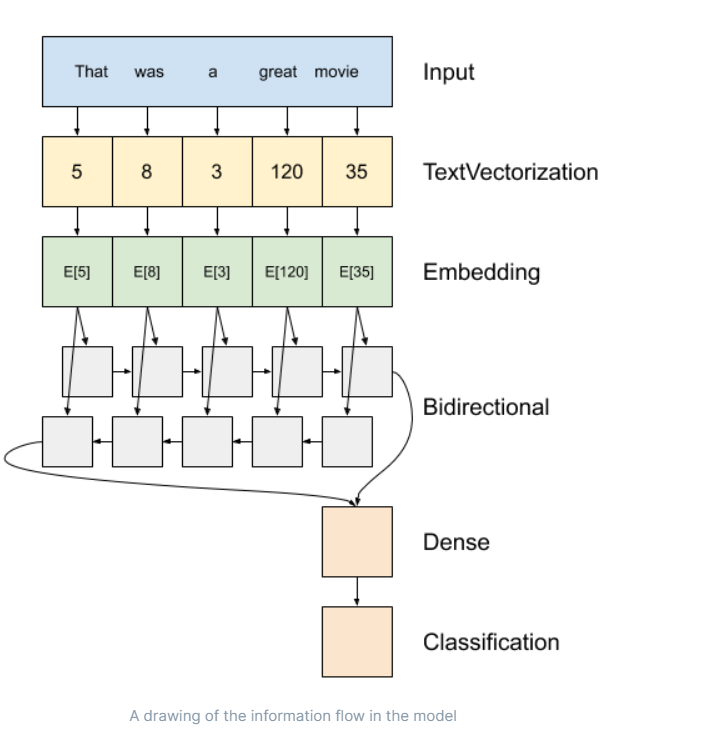

diagram model dapat dilihat pada gambar diatas

Model ini dapat dibuat sebagai tf.keras.Sequential.
Lapisan pertama adalah encoder, yang mengubah teks menjadi urutan indeks token.
Setelah encoder adalah lapisan penyematan (embedding layer). Lapisan penyematan menyimpan satu vektor per kata. Saat dipanggil, ini mengubah rangkaian indeks kata menjadi rangkaian vektor. Vektor-vektor ini dapat dilatih. Setelah pelatihan (dengan data yang cukup), kata-kata dengan arti yang mirip sering kali memiliki vektor yang serupa. Pencarian indeks ini jauh lebih efisien daripada operasi setara dengan meneruskan vektor yang disandikan one-hot melalui lapisan tf.keras.layers.Dense.
Jaringan saraf berulang (RNN) memproses masukan urutan dengan melakukan iterasi melalui elemen. RNN meneruskan keluaran dari satu langkah waktu ke masukannya pada langkah waktu berikutnya.
Pembungkus tf.keras.layers.Bidirection juga dapat digunakan dengan lapisan RNN. Ini menyebarkan masukan maju dan mundur melalui lapisan RNN dan kemudian menggabungkan keluaran akhir.

-**Keuntungan utama RNN dua arah** adalah sinyal dari awal masukan tidak perlu diproses sepanjang waktu untuk memengaruhi keluaran.

-**Kerugian utama dari RNN dua arah** adalah Anda tidak dapat melakukan streaming prediksi secara efisien saat kata-kata ditambahkan di akhir. 5. Setelah RNN mengonversi urutan menjadi satu vektor, kedua lapisan tersebut.Dense melakukan beberapa pemrosesan akhir, dan mengonversi representasi vektor ini menjadi logit tunggal sebagai keluaran klasifikasi.

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan:

In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[-0.00749642]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama:

In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 326ms/step
[-0.00749642]


compile model Keras untuk mengonfigurasi proses pelatihan:

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

**Train Model**

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

In [15]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 143s 350ms/step - loss: 0.6934 - accuracy: 0.5000
Test Loss: 0.6933531761169434
Test Accuracy: 0.5


NameError: ignored

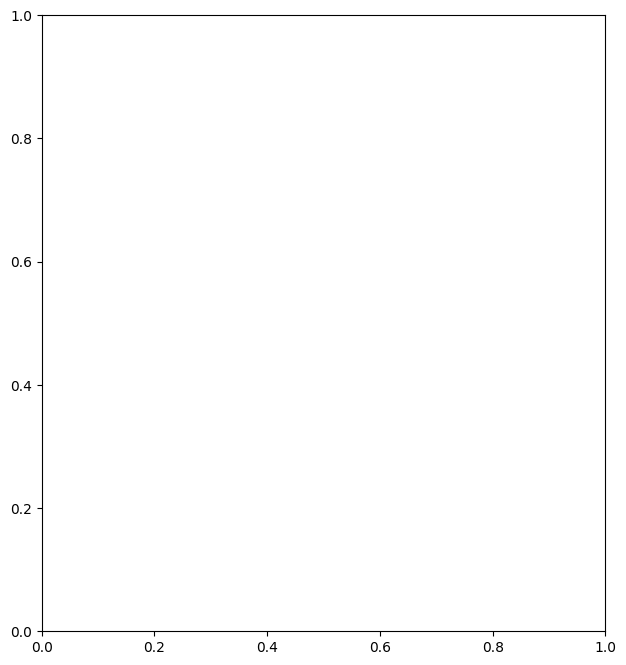

In [18]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.

In [19]:
sample_text = ('The movie was cool. The animation and the graphics '
'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


**Stack two or more LSTM layers**

In [20]:
model = tf.keras.Sequential([
     encoder,
     tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Dropout(0.5),
     tf.keras.layers.Dense(1)
])

In [21]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

In [23]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 275s 689ms/step - loss: 0.6931 - accuracy: 0.5000
Test Loss: 0.6931032538414001
Test Accuracy: 0.5


In [24]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 7s 7s/step
[[-0.00292815]]


NameError: ignored

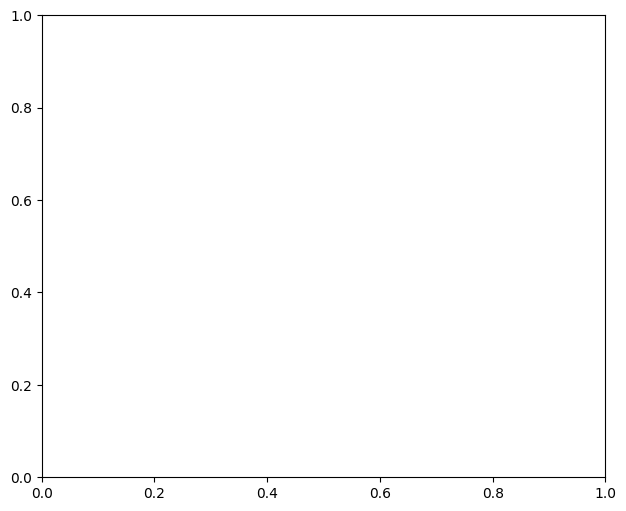

In [25]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')


**Praktikum 2**

**Generator Teks dengan RNN**

Setup

Import TensorFlow

In [26]:
import tensorflow as tf
import numpy as np
import os
import time

In [28]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


Load Data

In [29]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [30]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [31]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


**Olah Teks**

Vectorize Teks Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. tf.keras.layers.StringLookup dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [32]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

sekarang buat tf.keras.layers.StringLookup layer:

In [33]:
ids_from_chars = tf.keras.layers.StringLookup(
vocabulary=list(vocab), mask_token=None)

perintah diatas mengconvert token menjadi id

In [34]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

Karena tujuan tutorial ini adalah untuk menghasilkan teks, penting juga untuk membalikkan representasi ini. Untuk ini Anda dapat menggunakan kode

In [35]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

Lapisan ini mengconvert kembali karakter dari vektor ID, dan mengembalikannya sebagai karakter tf.RaggedTensor:

In [36]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

Anda dapat menggunakan tf.strings.reduce_join untuk menggabungkan kembali karakter menjadi string.

In [37]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [38]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

**Prediksi**

**Membuat Trianing Set dan Target**

In [39]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [40]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [41]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [42]:
seq_length = 100

Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [43]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string:

In [45]:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Untuk pelatihan, Anda memerlukan kumpulan data pasangan (input, label). Dimana input dan label merupakan urutan. Pada setiap langkah waktu, inputnya adalah karakter saat ini dan labelnya adalah karakter berikutnya. Berikut adalah fungsi yang mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu:

In [46]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [47]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [48]:
dataset = sequences.map(split_input_target)

In [49]:
for input_example, target_example in dataset.take(1):
 print("Input :", text_from_ids(input_example).numpy())
 print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


**Membuat Batch Training**

Anda menggunakan tf.data untuk membagi teks menjadi sequence yang dapat diatur. Namun sebelum memasukkan data ini ke dalam model, Anda perlu mengacak data dan mengemasnya ke dalam batch.

In [50]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

**Membuat Model**

In [51]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [52]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [53]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

**Uji Model**

In [54]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [55]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
sampled_indices = tf.random.categorical(example_batch_predictions[0],num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [57]:
sampled_indices

array([21, 43, 22, 11, 17, 43, 48,  1,  8, 24, 24, 56, 37, 63, 47, 13, 45,
       20, 44, 59, 27, 48, 15, 12, 12, 36, 44,  0, 35, 41,  8, 61, 55, 18,
       37, 59, 53, 49, 48, 15, 34, 54, 56, 29, 36,  4, 62, 16, 44, 59, 20,
       31, 49, 10, 11, 65, 20, 43, 28,  5,  2, 10, 53, 56, 26,  6, 19, 59,
       16, 58,  3, 37,  3,  3, 42, 65, 64, 19, 11,  9, 32, 50, 37, 49,  4,
       58, 44,  2, 25, 15, 40, 10, 59, 62, 13, 26, 30,  2, 52, 33])

Dekode kode berikut untuk melihat teks yang diprediksi oleh model tidak terlatih ini:

In [58]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())


Input:
 b" queen is at your house;\nFor God's sake, fairly let her be entreated:\nTell her I send to her my kind"

Next Char Predictions:
 b"HdI:Ddi\n-KKqXxh?fGetNiB;;We[UNK]Vb-vpEXtnjiBUoqPW$wCetGRj3:zGdO& 3nqM'FtCs!X!!czyF:.SkXj$se LBa3tw?MQ mT"


**Train Model**

Tambahan optimizer dan fungsi loss

loss function tf.keras.losses.sparse_categorical_crossentropy standar berfungsi dalam kasus ini karena diterapkan di seluruh dimensi terakhir prediksi. Karena model Anda mengembalikan logits, Anda perlu mengatur flag from_logits.

In [59]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [60]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.190141, shape=(), dtype=float32)


Model yang baru diinisialisasi tidak boleh terlalu yakin dengan dirinya sendiri, semua log keluaran harus memiliki besaran yang sama. Untuk mengonfirmasi hal ini, Anda dapat memeriksa bahwa eksponensial dari loss rata-rata harus kira-kira sama dengan ukuran kosakata. Loss yang jauh lebih tinggi berarti model tersebut yakin akan jawaban yang salah, dan memiliki inisialisasi yang buruk:

In [61]:
tf.exp(example_batch_mean_loss).numpy()

66.03211

Konfigurasikan prosedur pelatihan menggunakan metode tf.keras.Model.compile. Gunakan tf.keras.optimizers.Adam dengan argumen default dan fungsi loss.

In [62]:
model.compile(optimizer='adam', loss=loss)

**Konfigurasi Checkpoints**

Gunakan tf.keras.callbacks.ModelCheckpoint untuk memastikan bahwa checkpoint disimpan selama pelatihan:

In [63]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

Lakukan Proses Training

In [64]:
EPOCHS = 10


In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

**Generate Teks**

Berikut ini membuat prediksi satu langkah:

In [66]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states


In [67]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [68]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:YVXq:ABC,KPNFRGEPB VRCrreifpu 
 a$L;ey.m:&SZryLOFQh:;smp.
vwNouNIRbQxUnYIIa;D
bVy:U:GL'JbDAshaqNjhCheabDmCDuH Zf,YvclgpDAdt'ZXmt
uH.3H JkQqPCi:qitv
ENDJ:s3:k$FcvMi'Cj3cERI&?IlrZ$dL'VUVWU?nElvfiiptKvEF&EPno&H?uYEdX-r-kPmDuPZaFh:f;tBYqTgAp!aPZaVH;N;e!UsAJYJRM$aTIRSg!ZhMnBaDb$mCZmYj$ATQy yqCX3!'$, YLeCqAuaAJKYZeC rIGhsq$PMaiaUueP&Xuapfi T!SpQdlDxA-mpq.xoRPgK!jhGNTpqmOyueacK?e?MRELOFx'EXV:;VIUsWLLRGkeRjPgEhqAVAecyftR!f izaWx.c$F,SqHulr$fnYcZlJo:'-w'qIQdpbSIc-RONMbufxukCFPC--czxb-BO-$'n Gpt;3cXsmiMuQVDpTVfVSR$sbChiZk
ZKmZbiwEK.ftl.sV
kAS.;E'DGF'pSZUrVYSHTe3zXh Icw?':GUsT-fwM:Z?$SvTJuVaz!eb;Ci
VVXCJ,FnQ.QtYrjaxIoVzat!nri:TUP$jyjLCMs;;3oo ZX.DsIFbTPxKc3Z3rcoh,uIQSPUG.TETlprxqPUpMdqu?c&!hXWR
pU HgfWroH?wbCUQWFSHpmdx:Gf,xO''H3rCL$hYolbYaoGZ-3.V
dwSLwRQ!SpcroMeyyMO.dFZLiV,?QlDUW;v!jHaaRn;otNFnem yeaokUy
fWcFphj-I3XKpv'mj!iNmraJZvsmV$Qo?zdtmxs
&Lt-PTzJFjZ'gxYQ?QYZj&G FXU$hQZTcWpFR-eZV
hs!SLLVtPI nNj:Um
huf-,mMpucjA3MRtq3mywyT!Wdy&bPTCM.zRHmov,OWcvwYKA,aVoeGOHJGcWz3ZHBpfmrpy;bfdmQGxG!Mm!S3 J

In [69]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO: jRQfgVrojBWqd !gx3x'CxXfJmy$S'$WKmbYMITYcxJIB?3whS$abn:hWKd'B'fpg$CDA3-!!MweL$M:smbssZ?Trd&e3WSbFirMgF3h$-PWgv!:'tar&,lNj&''WWKqIblad-X;HWDmRrdAzBt zdUQMuCEXdGjTe&OPYMTztKV:DsV?hRjfwjgfTb!.cnU:LdgW..pHN!;$MKjN.u,q:&SQXco JN's-!j-DYv\nML''hMas.OQKyxzwTBH&wHBzNqzcUKbJ?!rmei,vINrEMP$YuGf,OnF\nQ$oIbFzrgYap,uZUP$ecO O&tKoubz-UiWpHE;pKpK!Ylq lCLb\njiMSKcV?evb;hbxz&sSrrBrJ3; .MBN3m.JoB,DgH H\n g$fiLZegYVz.wWis-t U&tXR-uoFA?xH'Wk3sW;D;pTxZAYy,vkFiMCVtr; 'U eYCnXjrvs:FlDkoFRKtLdTE\nRJkIOJAx:EtFbHnpS$SWy!BsZSTKZtqA'qFiiu dFvFdRT;YQnvnwIW.wjhfL.mBCMxlTJNJoJ3AqBm?JjK-rR OdKxBm?3dr:kIJvYOd-w.S IUQuyrk-NBuMQ?ml?kwj;xR\n,Yw 3wXzRslDH:Rz VXz3F:DCsrlz?hpVPA?t&.DiUGi:J?$zWnXHVHMiHVfpesFMR EHq:kfDrDdWzt D v'WV$lfaNmDACtcMmbUTWhl\nWn-MFIi\nXCUk!oHX:tp toot3IcxQyy?MOzZbCRvmWIYenoxwI-Cr-\ngR$:x,FtPj;vXDdgDuBqAy'\ncBsTpOWTBtlu-z\n&QpH;Lyz\nayPIxQ!.a&ix'F FplR &uo?us&xT?&uKY-UXs\nIb hkIsQNMx nEBoPmqguAyHcNt\nEGKNwbyffYjjF;jHIX,h; J;YsbyXAZCRo;bKn&, x-a;Vrxi'XfWp3QBjbQDsW!3fceTpVzeQwCBVM-n

**Ekspor Model Generator**

In [70]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [71]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
gyuN-YmrPxsQzOne ,

QCpSZioSeAm$;I3'QX$WaihAHCrD;q.ax3A-vZy!-LyZmKMXAn:;nIKDdK3ZH?
CFY t htLV:d'isP


**TUGAS**

In [72]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs, training=True)
      loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

In [73]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [74]:
model.compile(optimizer = tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [75]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 862s 5s/step - loss: 2.7276


In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
  start = time.time()

  mean.reset_states()
  for (batch_n, (inp, target)) in enumerate(dataset):
    logs = model.train_step([inp, target])
    mean.update_state(logs['loss'])

    if batch_n % 50 == 0:
      template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
      print(template)

  # saving (checkpoint) the model every 5 epochs
  if (epoch + 1) % 5 == 0:
    model.save_weights(checkpoint_prefix.format(epoch=epoch))

  print()
  print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
  print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
  print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.2179
Epoch 1 Batch 50 Loss 2.0646
Epoch 1 Batch 100 Loss 1.9992
Epoch 1 Batch 150 Loss 1.8637

Epoch 1 Loss: 1.9987
Time taken for 1 epoch 921.92 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8276
Epoch 2 Batch 50 Loss 1.8031
Epoch 2 Batch 100 Loss 1.7082
Epoch 2 Batch 150 Loss 1.6568

Epoch 2 Loss: 1.7243
Time taken for 1 epoch 861.91 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.6124
Epoch 3 Batch 50 Loss 1.6044
Epoch 3 Batch 100 Loss 1.5851
Epoch 3 Batch 150 Loss 1.5087

Epoch 3 Loss: 1.5644
Time taken for 1 epoch 841.02 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.5196
Epoch 4 Batch 50 Loss 1.4900
Epoch 4 Batch 100 Loss 1.4689
Epoch 4 Batch 150 Loss 1.3707

Epoch 4 Loss: 1.4642
Time taken for 1 epoch 861.91 sec
_________________________________________________________________

**SOAL**

Jalankan kode diatas dan sebutkan perbedaanya dengan praktikum 2?

**JAWAB**

Perbedaan antara kode tugas dengan praktikum 2 terletak pada prosedur pelatihan. Pada praktikum 2 menggunakan pendekatan pelatihan yang lebih sederhana dan umum digunakan, dengan 'model.fit'. Sedangkan kode pada tugas menggambarkan pendekatan pelatihan yang lebih spesifik dan kompleks, yang dilakukan beberapa kustomisasi. Dalam pendekatan ini, mendefinisikan metode train_step dalam model turunan yang mengatur pelatihan pada tingkat batch. Secara eksplisit dilakukan perhitungan loss, gradien, dan menerapkan pembaruan bobot model dengan apply_gradients, serta menggunakan objek tf.metrics.Mean untuk menghitung rata-rata loss selama pelatihan. Pendekatan ini memberikan lebih banyak kontrol dan fleksibilitas dalam pengaturan pelatihan model.